In [32]:
#!pip install keras --upgrade
#!pip install tensorflow --upgrade
#!pip install imblearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from skimage import feature
from imblearn.under_sampling import RandomUnderSampler
from skimage import feature, draw
from skimage.transform import hough_circle, hough_circle_peaks
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
import imblearn as imb
from sklearn.metrics import f1_score


2024-10-17 21:04:20.208527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train1_extra = np.load('Xtrain1_extra.npy')
# Size of the training set

print(X_train.shape) # 2700 images of size 48x48

# Hot Encoding the labels
train_labels = keras.utils.to_categorical(y_train,2)

(2783, 2304)


## Pre-Treatment

In [4]:
im = X_train.reshape(X_train.shape[0],48,48)    # Reshape the images to 48x48

new = im.copy() # Copy the images to a new array

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0



#m = im.imshow(im,cmap='gray')
#im = im(as_grey=True)
#new = filters.gaussian(new,sigma=0.5)  # Ajusta sigma para controlar el nivel de suavizado
#new= filters.median(new)  # Ajusta sigma para controlar el nivel de suavizado
#image_gaussian = feature.canny(im, sigma=3)  # Ajusta sigma según el nivel de detección de bordes

In [15]:
#Flatten the images
X_train_processed = new.reshape(new.shape[0],48*48)

[0 0 0 ... 0 0 0]


## Data Imbalance

### The imbalance

In [16]:
print("The number of training samples with class 0 :", np.sum(y_train==0))
print("The number of training samples with class 1 :", np.sum(y_train==1))
print("The percentage of training samples with class 0 :", np.sum(y_train==0)/np.sum(y_train==1))

The number of training samples with class 0 : 1006
The number of training samples with class 1 : 1777
The percentage of training samples with class 0 : 0.566122678671919


### Random under-sampling

We remove randomly the saples from class 1 

In [32]:
#Random undersampling
rus = imb.under_sampling.RandomUnderSampler(sampling_strategy=np.sum(y_train==0)/np.sum(y_train==1))

X_train_RUS, y_train_RUS = rus.fit_resample(X_train_processed, y_train)
X_train_RUS, X_val_RUS, y_train_RUS, y_val_RUS = train_test_split(X_train_RUS,y_train_RUS, test_size=0.2)

# One hot encoding
train_labels_RUS = keras.utils.to_categorical(y_train_RUS,2)
val_labels_RUS = keras.utils.to_categorical(y_val_RUS,2)

(2782, 2304)


### Random over-sampling

We randomly replicate data from class 0 to have the same amount as class 1.


IT CAN INCREASE OVERFITTING !!

In [42]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)

X_train_ROS, y_train_ROS = ros.fit_resample(X_train_processed, y_train)
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train_ROS, y_train_ROS, test_size=0.2)

# One hot encoding
train_labels_ROS = keras.utils.to_categorical(y_train_ROS,2)
val_labels_ROS = keras.utils.to_categorical(y_val_ROS,2)

print("The number of training samples with class 0 after ROS :", np.sum(y_train_ROS==0)+np.sum(y_val_ROS==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_train_ROS==1)+np.sum(y_val_ROS==1))

The number of training samples with class 0 after ROS : 1777
The number of training samples with class 1 after ROS : 1777


### Modified SMOTE

We randomly choose a subset of the minority class and we randomly create new samples. 

We use a modified version because SMOTE is not effective on high dimensional datasets.

In [39]:
# Modified SMOTE : MSMOTE


## Machine Learning with Neural Network

### Creating the Model

The size of input layer is : $48*48$ 

The number of hidden layers is between 2 and 5: giving the number of samples. 
2 if under 10 000 samples.

In [58]:
# Neural network
model = Sequential()

#0.95 with  256 -> 128 -> 64 -> 2
#0.88 with 128 -> 64 -> 32 -> 2
#0.81 with 128 -> 64 -> 32 -> 16 -> 2
#0.86 with 256 -> 128 -> 64 -> 32 -> 2


# Input layer
model.add(Dense(256, input_shape=(48*48,), activation='relu')) 
model.add(Dense(128, activation='relu'))
model.add(Dense((64), activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.summary()

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,362 (2.41 MB)

 Trainable params: 631,362 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

### Regularization

In [59]:
batch_size=50
epochs=150
lr=0.001

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6141 - loss: 8.3978 - val_accuracy: 0.6984 - val_loss: 2.1835
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9221 - loss: 0.8363 - val_accuracy: 0.7307 - val_loss: 1.8069
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9714 - loss: 0.2814 - val_accuracy: 0.7469 - val_loss: 1.8934
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9955 - loss: 0.1125 - val_accuracy: 0.7720 - val_loss: 1.8781
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9942 - loss: 0.1371 - val_accuracy: 0.7594 - val_loss: 1.7567
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0356 - val_accuracy: 0.7487 - val_loss: 1.9132
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9846 - loss: 0.1606 - val_accuracy: 0.7415 - val_loss: 2.3080
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9913 - loss: 0.1270 - val_accuracy: 0.

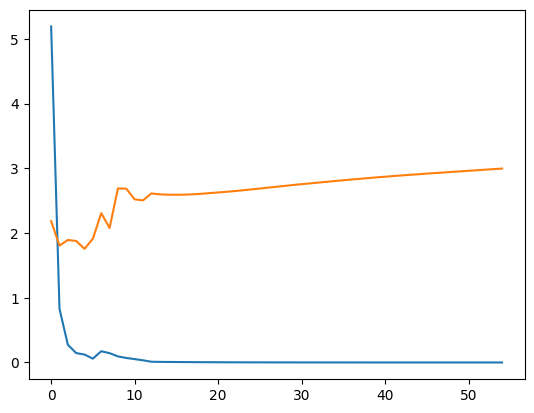

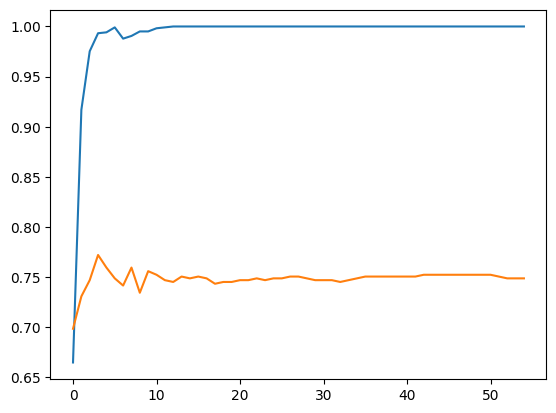

([<matplotlib.lines.Line2D at 0x7f94a2038b50>], None)

In [60]:
adam = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer = adam,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


# Définir le callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # The quantity to be monitored
    patience=50,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # restore the best model
    mode='min',           # consider the quantity to be monitored as minimum
    verbose=1             # a message will be printed
)

#MLP with early stopping
history = model.fit(x = X_train_RUS,
                    y=train_labels_RUS,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_RUS,val_labels_RUS),
                    callbacks = [early_stopping],
                    verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='validation'), plt.show()
plt.plot(history.history['accuracy'], label='train'),
plt.plot(history.history['val_accuracy'], label='validation'), plt.show()



Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9415 - loss: 0.6230 - val_accuracy: 0.8453 - val_loss: 3.4743
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9299 - loss: 1.4484 - val_accuracy: 0.8636 - val_loss: 1.2952
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9589 - loss: 0.4629 - val_accuracy: 0.9128 - val_loss: 0.7285
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9704 - loss: 0.2224 - val_accuracy: 0.8931 - val_loss: 0.9415
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9874 - loss: 0.1182 - val_accuracy: 0.9086 - val_loss: 0.8486
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9974 - loss: 0.0156 - val_accuracy: 0.9030 - val_loss: 1.2564
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9870 - loss: 0.1676 - val_accuracy: 0.8186 - val_loss: 1.8331
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9809 - loss: 0.1884 - val_accuracy: 0.

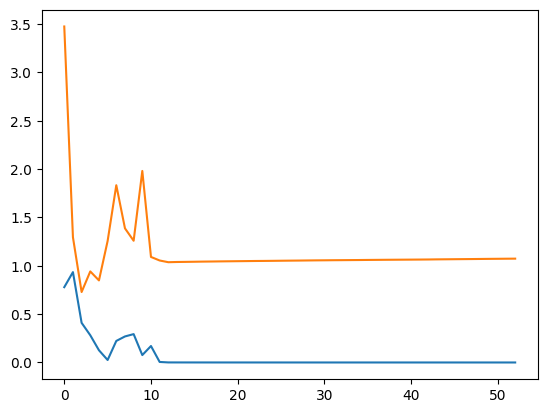

([<matplotlib.lines.Line2D at 0x7f94a313cd30>], None)

In [61]:

adam = keras.optimizers.Adam(learning_rate = lr)
model.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])


#MLP with early stopping
history = model.fit(x = X_train_ROS,
                    y=train_labels_ROS,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_ROS,val_labels_ROS),
                    callbacks = [early_stopping],
                    verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='train'), plt.show()


## Using X_extra

We can use X_extra and do prediction on it and then combine X_train and X_extra

In [70]:
im = X_train1_extra.reshape(X_train1_extra.shape[0],48,48)    # Reshape the images to 48x48

new = im.copy() # Copy the images to a new array

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

In [72]:
X_train_extra_processed = new.reshape(new.shape[0],48*48)

(904, 2304)


In [73]:
# Predictions
y_pred = model.predict(X_train_extra_processed)
y_pred = np.argmax(y_pred, axis=1)
print("The number of extra samples with class 0 :", np.sum(y_pred==0))
print("The number of extra samples with class 1 :", np.sum(y_pred==1))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The number of extra samples with class 0 : 452
The number of extra samples with class 1 : 452


In [89]:
# Adding the extra samples to the training set for class 0
X_train_combined = np.concatenate((X_train_processed,X_train_extra_processed[y_pred==0]),axis=0)
y_train_combined = np.concatenate((y_train,y_pred[y_pred==0]),axis=0)
train_labels_ROS_combined = keras.utils.to_categorical(y_train_combined,2)
print("The number of training samples with class 0 after adding extra samples :", np.sum(y_train_combined==0))
print("The number of training samples with class 1 after adding extra samples :", np.sum(y_train_combined==1))

# ROS
ros = imb.over_sampling.RandomOverSampler(random_state=None)
X_train_ROS_combined, y_train_ROS_combined = ros.fit_resample(X_train_combined, y_train_combined)
X_train_ROS_combined, X_val_ROS_combined, y_train_ROS_combined, y_val_ROS_combined = train_test_split(X_train_ROS_combined, y_train_ROS_combined, test_size=0.2)
train_labels_ROS_combined = keras.utils.to_categorical(y_train_ROS_combined,2)
val_labels_ROS_combined = keras.utils.to_categorical(y_val_ROS_combined,2)

The number of training samples with class 0 after adding extra samples : 1458
The number of training samples with class 1 after adding extra samples : 1777


Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9735 - loss: 0.5485 - val_accuracy: 0.9592 - val_loss: 0.5716
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9943 - loss: 0.0220 - val_accuracy: 0.9662 - val_loss: 0.4990
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9958 - loss: 0.0932 - val_accuracy: 0.9662 - val_loss: 0.8537
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9928 - loss: 0.0897 - val_accuracy: 0.9733 - val_loss: 0.6261
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9954 - loss: 0.3742 - val_accuracy: 0.9620 - val_loss: 0.6117
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9946 - loss: 0.2725 - val_accuracy: 0.9606 - val_loss: 0.6629
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 0.9578 - val_loss: 0.8260
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 4.5025e-05 - val_accuracy

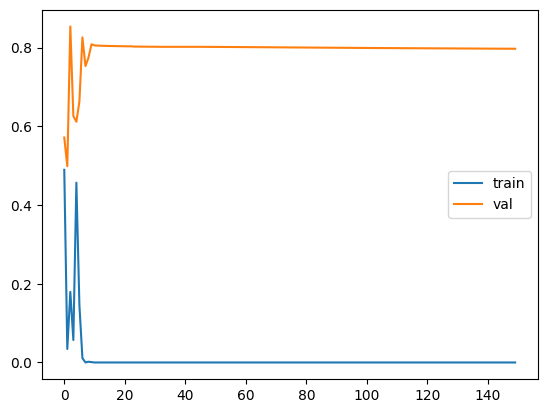

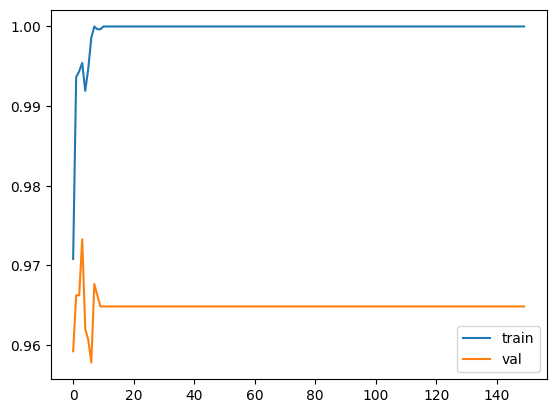

(<matplotlib.legend.Legend at 0x7f94923118b0>, None)

In [90]:
# Training the model
adam = keras.optimizers.Adam(learning_rate = lr)


model.compile(optimizer = adam,
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

#MLP without early stopping
history = model.fit(x = X_train_ROS_combined,
                    y=train_labels_ROS_combined,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_ROS_combined,val_labels_ROS_combined),
                    callbacks = [early_stopping],
                    verbose = 1)

####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='val'), 
plt.legend(),plt.show()
plt.plot(history.history['accuracy'], label='train'),
plt.plot(history.history['val_accuracy'], label='val'),
plt.legend(),plt.show()



In [95]:

# Cross validation with keras and scikit-learn f1 score on validation set
from sklearn.model_selection import StratifiedKFold

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
f1 = []
print(X_train_ROS_combined.shape)
print(y_train_ROS_combined.shape)
for train, test in kfold.split(X_train_ROS_combined, y_train_ROS_combined):
  # Validation set

  model = Sequential()
  model.add(Dense(256, input_shape=(48*48,), activation='relu')) 
  model.add(Dense(128, activation='relu'))
  model.add(Dense((64), activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  adam = keras.optimizers.Adam(learning_rate = lr)
  model.compile(optimizer = adam,
                loss = ['binary_crossentropy'],
                metrics=['accuracy'])

  # Fit data to model
  history = model.fit(X_train_ROS_combined[train], train_labels_ROS_combined[train],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_train_ROS_combined[test], train_labels_ROS_combined[test]),
                      callbacks = [early_stopping]
                      )

  # Generate generalization metrics on validation set
  scores = model.evaluate(X_train_ROS_combined[test], train_labels_ROS_combined[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  f1.append(f1_score(np.argmax(train_labels_ROS_combined[test],axis=1),np.argmax(model.predict(X_train_ROS_combined[test]),axis=1)))
  fold_no += 1



(2843, 2304)
(2843,)


/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6140 - loss: 5.5886 - val_accuracy: 0.6982 - val_loss: 2.5865
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9310 - loss: 0.5985 - val_accuracy: 0.7544 - val_loss: 2.8177
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9798 - loss: 0.2378 - val_accuracy: 0.7228 - val_loss: 2.6842
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9874 - loss: 0.2240 - val_accuracy: 0.7404 - val_loss: 2.9607
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9905 - loss: 0.1059 - val_accuracy: 0.7263 - val_loss: 2.9542
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9964 - loss: 0.0752 - val_accuracy: 0.7509 - val_loss: 3.3319
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9947 - loss: 0.2183 - val_accuracy: 0.7439 - val_loss: 2.7355
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9868 - loss: 0.1497 - val_accuracy: 0.

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6134 - loss: 5.2507 - val_accuracy: 0.7263 - val_loss: 2.1481
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9144 - loss: 0.6497 - val_accuracy: 0.7754 - val_loss: 1.5568
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9913 - loss: 0.1282 - val_accuracy: 0.7684 - val_loss: 1.7550
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9906 - loss: 0.1597 - val_accuracy: 0.7649 - val_loss: 1.9351
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9936 - loss: 0.0697 - val_accuracy: 0.7965 - val_loss: 1.7177
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9970 - loss: 0.0480 - val_accuracy: 0.7895 - val_loss: 1.6191
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9967 - loss: 0.0650 - val_accuracy: 0.7754 - val_loss: 1.6969
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9967 - loss: 0.0528 - val_accuracy: 0.

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5777 - loss: 6.8387 - val_accuracy: 0.7719 - val_loss: 2.1868
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9140 - loss: 0.9116 - val_accuracy: 0.7895 - val_loss: 1.5967
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9801 - loss: 0.2708 - val_accuracy: 0.7789 - val_loss: 1.6988
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9935 - loss: 0.1304 - val_accuracy: 0.8105 - val_loss: 1.7575
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9947 - loss: 0.1016 - val_accuracy: 0.8000 - val_loss: 1.5882
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9951 - loss: 0.1135 - val_accuracy: 0.7860 - val_loss: 1.9691
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9958 - loss: 0.0866 - val_accuracy: 0.7825 - val_loss: 1.6680
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9949 - loss: 0.1143 - val_accuracy: 0.7825 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5920 - loss: 5.8250 - val_accuracy: 0.6831 - val_loss: 2.1103
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9377 - loss: 0.4784 - val_accuracy: 0.6761 - val_loss: 2.3379
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9794 - loss: 0.2197 - val_accuracy: 0.6972 - val_loss: 2.0316
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9872 - loss: 0.2863 - val_accuracy: 0.7007 - val_loss: 2.2872
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9916 - loss: 0.1039 - val_accuracy: 0.7113 - val_loss: 2.8642
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9910 - loss: 0.1238 - val_accuracy: 0.7077 - val_loss: 2.4997
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9870 - loss: 0.1628 - val_accuracy: 0.7148 - val_loss: 2.7154
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9802 - loss: 0.2426 - val_accuracy: 0.6937 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6054 - loss: 7.2418 - val_accuracy: 0.7183 - val_loss: 1.7092
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9089 - loss: 0.8162 - val_accuracy: 0.7113 - val_loss: 1.3848
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9695 - loss: 0.3061 - val_accuracy: 0.7852 - val_loss: 1.3357
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9948 - loss: 0.1231 - val_accuracy: 0.7570 - val_loss: 1.3268
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9946 - loss: 0.0913 - val_accuracy: 0.7852 - val_loss: 1.3299
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9986 - loss: 0.0353 - val_accuracy: 0.7746 - val_loss: 1.4172
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9995 - loss: 0.0331 - val_accuracy: 0.7852 - val_loss: 1.4966
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 0.7782 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6563 - loss: 5.6353 - val_accuracy: 0.6831 - val_loss: 1.8489
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9381 - loss: 0.5473 - val_accuracy: 0.7183 - val_loss: 1.7590
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9911 - loss: 0.1622 - val_accuracy: 0.7077 - val_loss: 1.9866
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9969 - loss: 0.0765 - val_accuracy: 0.7077 - val_loss: 1.7773
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9967 - loss: 0.1141 - val_accuracy: 0.7430 - val_loss: 1.9657
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9952 - loss: 0.1051 - val_accuracy: 0.7324 - val_loss: 1.7994
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9963 - loss: 0.0860 - val_accuracy: 0.7394 - val_loss: 2.3147
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9939 - loss: 0.0483 - val_accuracy: 0.7359 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6130 - loss: 6.8823 - val_accuracy: 0.7042 - val_loss: 2.4552
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9380 - loss: 0.7379 - val_accuracy: 0.7394 - val_loss: 1.7860
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9725 - loss: 0.3114 - val_accuracy: 0.7711 - val_loss: 2.1917
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9934 - loss: 0.2338 - val_accuracy: 0.7394 - val_loss: 2.2688
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9976 - loss: 0.0591 - val_accuracy: 0.7641 - val_loss: 2.0923
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9959 - loss: 0.0608 - val_accuracy: 0.7782 - val_loss: 2.1392
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9991 - loss: 0.0512 - val_accuracy: 0.7641 - val_loss: 2.4140
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9970 - loss: 0.0742 - val_accuracy: 0.7042 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5934 - loss: 5.9739 - val_accuracy: 0.7570 - val_loss: 1.4406
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9284 - loss: 0.6667 - val_accuracy: 0.7782 - val_loss: 1.3709
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9904 - loss: 0.1325 - val_accuracy: 0.7923 - val_loss: 1.4151
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9941 - loss: 0.0927 - val_accuracy: 0.7570 - val_loss: 1.5853
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9987 - loss: 0.0558 - val_accuracy: 0.7324 - val_loss: 1.7581
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9951 - loss: 0.0733 - val_accuracy: 0.7782 - val_loss: 1.7048
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9987 - loss: 0.0481 - val_accuracy: 0.7887 - val_loss: 1.9377
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9993 - loss: 0.0259 - val_accuracy: 0.8028 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6101 - loss: 5.0124 - val_accuracy: 0.7007 - val_loss: 1.6357
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9111 - loss: 0.5858 - val_accuracy: 0.6725 - val_loss: 1.3384
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9562 - loss: 0.3112 - val_accuracy: 0.7465 - val_loss: 1.3298
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9861 - loss: 0.1544 - val_accuracy: 0.7676 - val_loss: 1.4104
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9954 - loss: 0.0964 - val_accuracy: 0.7359 - val_loss: 1.5322
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9863 - loss: 0.1423 - val_accuracy: 0.7641 - val_loss: 1.4019
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9909 - loss: 0.1137 - val_accuracy: 0.7535 - val_loss: 1.5177
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9879 - loss: 0.1222 - val_accuracy: 0.7394 - val_l

/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6023 - loss: 7.1723 - val_accuracy: 0.6937 - val_loss: 2.0619
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8918 - loss: 1.0285 - val_accuracy: 0.7183 - val_loss: 1.7156
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9844 - loss: 0.1467 - val_accuracy: 0.7641 - val_loss: 1.7606
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9950 - loss: 0.0724 - val_accuracy: 0.7570 - val_loss: 1.7026
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9992 - loss: 0.0429 - val_accuracy: 0.7500 - val_loss: 1.6895
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9969 - loss: 0.0507 - val_accuracy: 0.7641 - val_loss: 1.9438
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9960 - loss: 0.0435 - val_accuracy: 0.7570 - val_loss: 1.9741
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9888 - loss: 0.2367 - val_accuracy: 0.7113 - val_l

In [98]:
print(f1)

[0.7361963190184051, 0.6904761904761905, 0.7811447811447811, 0.7019867549668874, 0.7499999999999999, 0.7019867549668873, 0.6956521739130436, 0.7752442996742671, 0.711864406779661, 0.6614785992217899]
